<a href="https://colab.research.google.com/github/AnkurMali/IST597_Spring_2022/blob/main/IST597_MLP_withkeras_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import time
import tensorflow as tf
np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
tf.config.list_physical_devices('GPU')
tf.executing_eagerly()

True

In [3]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train=tf.reshape(x_train,[x_train.shape[0],-1])
x_test=tf.reshape(x_test,[x_test.shape[0],-1])
print(x_test.shape)
seed=1234
size_input = 784
size_hidden_1 = 256
size_hidden_2 = 128
size_output = 10
batch_size=100
NUM_EPOCHS=10


4431872/4422102 [==============================] - 0s 0us/step
(10000, 784)


https://www.tensorflow.org/datasets/keras_example for mnist load data/choose of loss function

In [4]:
class MLP(object):
  def __init__(self, size_input, size_hidden,size_hidden2,size_output,device="gpu",use_l1=False,use_l2=False,keep_prob=0.0):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden,self.size_hidden2, self.size_output, self.device, self.use_l1,self.use_l2,self.keep_prob =\
    size_input, size_hidden, size_hidden2, size_output, device,use_l1,use_l2,keep_prob
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden]))
     # Initialize weights between hidden layer and output layer
    
    #hide1
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden2]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden2]))

    #hide2
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, size_output]))

    #output
    #self.W4 = tf.Variable(tf.random.normal([128, self.size_output]))
    # Initialize biases for output layer
    #self.b4 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3,self.b1, self.b2,self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    #y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    l1=tf.keras.regularizers.L1(l1=0.00001)
    l2=tf.keras.regularizers.L2(l2=0.00001)
    L1=l1(self.W1) + l1(self.W2)+l1(self.W3)
    L2=l2(self.W1) + l2(self.W2)+l2(self.W3)
    
    final_loss=loss(y_true, y_pred)
    if self.use_l1:
      final_loss=final_loss+L1
    if self.use_l2:
      final_loss=final_loss+L2
    return final_loss
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    1e-3,
    decay_steps=600000,
    decay_rate=0.96,
    staircase=True)

    optimizer = tf.keras.optimizers.SGD(lr_schedule)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      
      current_loss = self.loss(predicted, y_train)
      #print(current_loss)
    
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
  
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what = tf.matmul(X_tf, self.W1) + self.b1
    input = tf.nn.relu(what)
    input = tf.nn.dropout(input, self.keep_prob)

    what1 = tf.matmul(input, self.W2) + self.b2
    hhat1 = tf.nn.relu(what1)
    hhat1 = tf.nn.dropout(hhat1, self.keep_prob)

    output = tf.matmul(hhat1, self.W3) + self.b3
    #hhat2 = tf.nn.relu(what2)
    #hhat2 = tf.nn.dropout(hhat2, self.keep_prob)
    # Compute output
    #output = tf.matmul(hhat2, self.W4) + self.b4
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [5]:
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(100, seed=seed).batch(batch_size)

In [6]:
def train(MLP,train_accuracy_store,train_loss_store,test_accuracy_store,test_loss_store):
  time_start = time.time()
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

  
  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

  train_accuracy.reset_states()
  test_accuracy.reset_states()
  for epoch in range(NUM_EPOCHS):
    #train_loss.reset_states()
    train_accuracy.reset_states()
    #test_loss.reset_states()
    test_accuracy.reset_states()
    
    for inputs, outputs in train_ds:
      MLP.backward(inputs, outputs)
      preds = MLP.forward(inputs)
      train_loss=MLP.loss(preds,outputs)
      train_accuracy(outputs, preds)

    for inputs, outputs in test_ds:
      preds = MLP.forward(inputs)
      test_loss=MLP.loss(preds,outputs)
      test_accuracy(outputs, preds)
    
    print('Number of Epoch = {} - Average loss:= {} - Accuracy :={} -Test Loss :={} - Test Accuracy :={}'.format(epoch + 1, train_loss.numpy(),train_accuracy.result() * 100, test_loss.numpy(),test_accuracy.result() * 100))
    train_accuracy_store.append(train_accuracy.result()*100)
    train_loss_store.append(train_loss.numpy())
    test_accuracy_store.append(test_accuracy.result() * 100)
    test_loss_store.append(test_loss.numpy())
  time_taken = time.time() - time_start

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

In [7]:
mlp_on_default = MLP(size_input, size_hidden_1, size_hidden_2, size_output,'gpu')
train_accuracy_store,train_loss_store,test_accuracy_store,test_loss_store=[],[],[],[]
train(mlp_on_default,train_accuracy_store,train_loss_store,test_accuracy_store,test_loss_store)


Number of Epoch = 1 - Average loss:= 31.526416778564453 - Accuracy :=67.26333618164062 -Test Loss :=63.8057746887207 - Test Accuracy :=71.87999725341797
Number of Epoch = 2 - Average loss:= 24.218406677246094 - Accuracy :=76.19666290283203 -Test Loss :=39.67477035522461 - Test Accuracy :=73.97999572753906
Number of Epoch = 3 - Average loss:= 17.485246658325195 - Accuracy :=77.69332885742188 -Test Loss :=30.1959171295166 - Test Accuracy :=75.55000305175781
Number of Epoch = 4 - Average loss:= 15.910745620727539 - Accuracy :=78.5616683959961 -Test Loss :=25.081754684448242 - Test Accuracy :=76.1300048828125
Number of Epoch = 5 - Average loss:= 12.004826545715332 - Accuracy :=78.94667053222656 -Test Loss :=20.960092544555664 - Test Accuracy :=76.3800048828125
Number of Epoch = 6 - Average loss:= 14.283281326293945 - Accuracy :=79.02333068847656 -Test Loss :=21.556316375732422 - Test Accuracy :=75.59000396728516
Number of Epoch = 7 - Average loss:= 8.048774719238281 - Accuracy :=79.0166702

[<tf.Tensor: shape=(), dtype=float32, numpy=67.263336>, <tf.Tensor: shape=(), dtype=float32, numpy=76.19666>, <tf.Tensor: shape=(), dtype=float32, numpy=77.69333>, <tf.Tensor: shape=(), dtype=float32, numpy=78.56167>, <tf.Tensor: shape=(), dtype=float32, numpy=78.94667>, <tf.Tensor: shape=(), dtype=float32, numpy=79.02333>, <tf.Tensor: shape=(), dtype=float32, numpy=79.01667>, <tf.Tensor: shape=(), dtype=float32, numpy=78.909996>, <tf.Tensor: shape=(), dtype=float32, numpy=78.855>, <tf.Tensor: shape=(), dtype=float32, numpy=78.649994>]


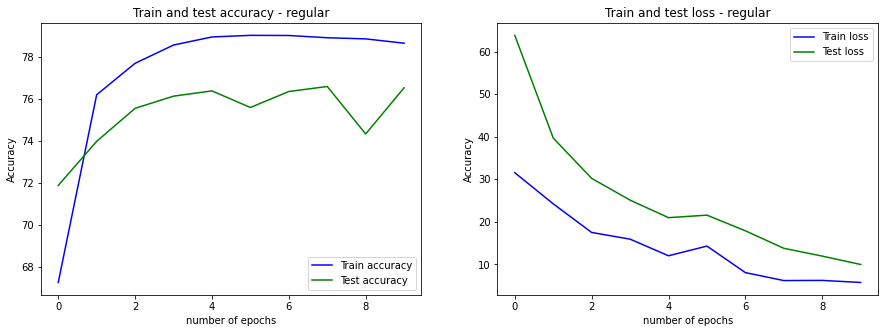

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
K = range(0,10)

plt.subplot(1,2,1)
plt.plot(K, train_accuracy_store, color='blue', label='Train accuracy')
plt.plot(K, test_accuracy_store, color='green', label='Test accuracy')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test accuracy - regular')
plt.legend()

plt.subplot(1,2,2)
plt.plot(K, train_loss_store, color='blue', label='Train loss')
plt.plot(K, test_loss_store, color='green', label='Test loss')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test loss - regular')
plt.legend()


print(train_accuracy_store)

In [10]:
mlp_L1_L2 = MLP(size_input, size_hidden_1, size_hidden_2, size_output,'gpu',True,True)
train_accuracy_store_mlp_L1_L2,train_loss_store_mlp_L1_L2,test_accuracy_store_mlp_L1_L2,test_loss_store_mlp_L1_L2=[],[],[],[]
train(mlp_L1_L2,train_accuracy_store_mlp_L1_L2,train_loss_store_mlp_L1_L2,test_accuracy_store_mlp_L1_L2,test_loss_store_mlp_L1_L2)

Number of Epoch = 1 - Average loss:= 33.05670928955078 - Accuracy :=67.05500030517578 -Test Loss :=46.902549743652344 - Test Accuracy :=72.1199951171875
Number of Epoch = 2 - Average loss:= 32.71281814575195 - Accuracy :=75.60166931152344 -Test Loss :=37.03006362915039 - Test Accuracy :=74.18000030517578
Number of Epoch = 3 - Average loss:= 30.133277893066406 - Accuracy :=77.03833770751953 -Test Loss :=31.12486457824707 - Test Accuracy :=75.72000122070312
Number of Epoch = 4 - Average loss:= 11.65412712097168 - Accuracy :=77.7249984741211 -Test Loss :=23.868715286254883 - Test Accuracy :=75.55999755859375
Number of Epoch = 5 - Average loss:= 15.696505546569824 - Accuracy :=77.91666412353516 -Test Loss :=19.518779754638672 - Test Accuracy :=75.88999938964844
Number of Epoch = 6 - Average loss:= 12.80732250213623 - Accuracy :=78.01166534423828 -Test Loss :=17.931316375732422 - Test Accuracy :=75.61000061035156
Number of Epoch = 7 - Average loss:= 9.6856689453125 - Accuracy :=77.910003662

[<tf.Tensor: shape=(), dtype=float32, numpy=67.263336>, <tf.Tensor: shape=(), dtype=float32, numpy=76.19666>, <tf.Tensor: shape=(), dtype=float32, numpy=77.69333>, <tf.Tensor: shape=(), dtype=float32, numpy=78.56167>, <tf.Tensor: shape=(), dtype=float32, numpy=78.94667>, <tf.Tensor: shape=(), dtype=float32, numpy=79.02333>, <tf.Tensor: shape=(), dtype=float32, numpy=79.01667>, <tf.Tensor: shape=(), dtype=float32, numpy=78.909996>, <tf.Tensor: shape=(), dtype=float32, numpy=78.855>, <tf.Tensor: shape=(), dtype=float32, numpy=78.649994>]


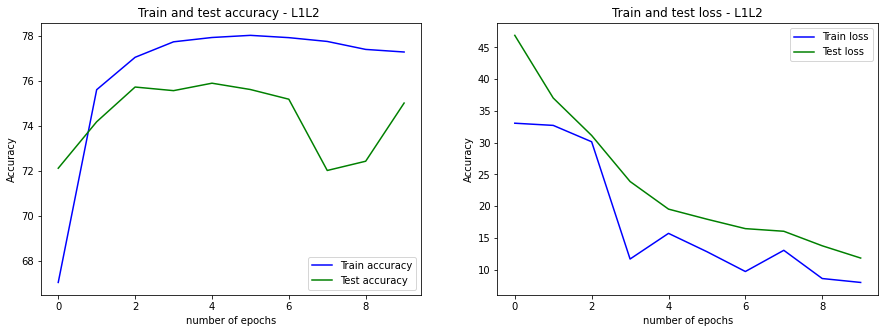

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
K = range(0,10)

plt.subplot(1,2,1)
plt.plot(K, train_accuracy_store_mlp_L1_L2, color='blue', label='Train accuracy')
plt.plot(K, test_accuracy_store_mlp_L1_L2, color='green', label='Test accuracy')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test accuracy - L1L2 ')
plt.legend()

plt.subplot(1,2,2)
plt.plot(K, train_loss_store_mlp_L1_L2, color='blue', label='Train loss')
plt.plot(K, test_loss_store_mlp_L1_L2, color='green', label='Test loss')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test loss - L1L2')
plt.legend()


print(train_accuracy_store)

In [12]:
mlp_L1_L2_dropout = MLP(size_input, size_hidden_1, size_hidden_2, size_output,'gpu',True,True,0.1)
train_accuracy_store_mlp_L1_L2_dropout,train_loss_store_mlp_L1_L2_dropout,test_accuracy_store_mlp_L1_L2_dropout,test_loss_store_mlp_L1_L2_dropout=[],[],[],[]
train(mlp_L1_L2_dropout,train_accuracy_store_mlp_L1_L2_dropout,train_loss_store_mlp_L1_L2_dropout,test_accuracy_store_mlp_L1_L2_dropout,test_loss_store_mlp_L1_L2_dropout)

Number of Epoch = 1 - Average loss:= 82.10265350341797 - Accuracy :=57.223331451416016 -Test Loss :=83.46578979492188 - Test Accuracy :=63.94000244140625
Number of Epoch = 2 - Average loss:= 33.55033874511719 - Accuracy :=65.2300033569336 -Test Loss :=39.92878341674805 - Test Accuracy :=64.96000671386719
Number of Epoch = 3 - Average loss:= 27.29332160949707 - Accuracy :=65.57166290283203 -Test Loss :=30.348217010498047 - Test Accuracy :=64.29000091552734
Number of Epoch = 4 - Average loss:= 18.906164169311523 - Accuracy :=64.88666534423828 -Test Loss :=21.528244018554688 - Test Accuracy :=63.52000427246094
Number of Epoch = 5 - Average loss:= 12.498658180236816 - Accuracy :=64.10833740234375 -Test Loss :=20.2340087890625 - Test Accuracy :=62.970001220703125
Number of Epoch = 6 - Average loss:= 9.090482711791992 - Accuracy :=62.731666564941406 -Test Loss :=19.29815101623535 - Test Accuracy :=61.30999755859375
Number of Epoch = 7 - Average loss:= 7.878478050231934 - Accuracy :=61.849998

[<tf.Tensor: shape=(), dtype=float32, numpy=67.263336>, <tf.Tensor: shape=(), dtype=float32, numpy=76.19666>, <tf.Tensor: shape=(), dtype=float32, numpy=77.69333>, <tf.Tensor: shape=(), dtype=float32, numpy=78.56167>, <tf.Tensor: shape=(), dtype=float32, numpy=78.94667>, <tf.Tensor: shape=(), dtype=float32, numpy=79.02333>, <tf.Tensor: shape=(), dtype=float32, numpy=79.01667>, <tf.Tensor: shape=(), dtype=float32, numpy=78.909996>, <tf.Tensor: shape=(), dtype=float32, numpy=78.855>, <tf.Tensor: shape=(), dtype=float32, numpy=78.649994>]


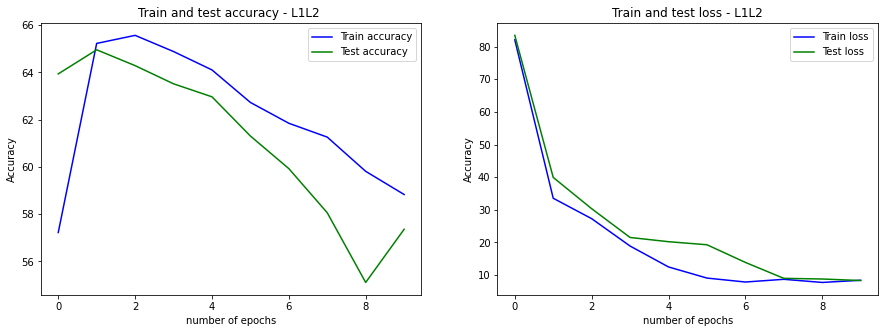

In [13]:

plt.figure(figsize=(15,5))
K = range(0,10)

plt.subplot(1,2,1)
plt.plot(K, train_accuracy_store_mlp_L1_L2_dropout, color='blue', label='Train accuracy')
plt.plot(K, test_accuracy_store_mlp_L1_L2_dropout, color='green', label='Test accuracy')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test accuracy - L1L2 ')
plt.legend()

plt.subplot(1,2,2)
plt.plot(K, train_loss_store_mlp_L1_L2_dropout, color='blue', label='Train loss')
plt.plot(K, test_loss_store_mlp_L1_L2_dropout, color='green', label='Test loss')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test loss - L1L2')
plt.legend()


print(train_accuracy_store)